# Keras Tuner

Keras Tuner es una biblioteca que ayuda a elegir el conjunto optimo de hiperparámetros para tu programa TensorFlow/Keras. El proceso para seleccionar el conjunto correcto de hiperparametros para su aplicación de aprendizaje automatico (ML) se llama _hyperparameter_ o _hypertuning_.

Los hiperparámetros son las variables que gobiernan el proceso de entrenamiento y la topología de un modelo de Machine Learning. Esas Variables permanecen constantes durante el proceso de entrenamiento e impactan directamente en el rendimiento del programa. Los hiperparámetros pueden ser de dos tipos:

* **Hiperparámetro del modelo** que influye en la selección del modelo, como el número y ancho de las hidden layers
* **Hiperparámetros de algoritmo** que influyen en la velocidad y calidad del algoritmo de aprendizaje, como la tasa de aprendizaje para el Descenso de Gradiente Estocástico (SGD).

## 0. Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

## 1. Conjunto de datos

In [4]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 1s 0us/step


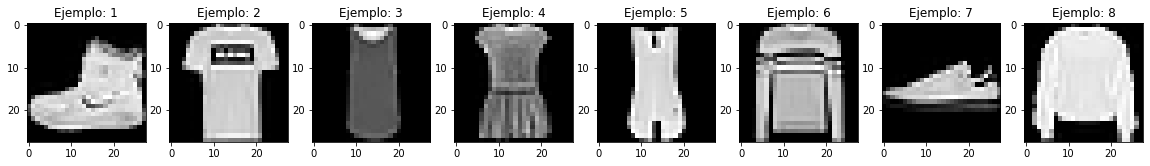

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))

for index, e in enumerate(img_train[:8]):
    plt.subplot(1, 8, index+1)
    plt.imshow(e, cmap=plt.cm.gray)
    plt.title('Ejemplo: ' + str(index+1))
    
plt.show()

In [6]:
# Normalizamos el valor de los pixeles entre 0 y 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

## 2. Definición del modelo

Cuando se construye un modelo para realizar el hypertuning, debe definirse el espacio de búsqueda de hiperparámetros además de la arquitectura del modelo. El modelo que estableces para realizar _hipertuning_ se llama _hypermodel_.

Puedes definir un _hypermodel_ a través de dos enfoques:
- Implementando una función que construye el modelo
- Creando una subclase la clase **HyperModel** de Keras Tuner API

También puedes utilizar dos clases predefinidas de **HyperModel**, **HyperXception** y **HyperResNet** para aplicaciones de visión artificial.

En este tutorial, se implementa una función que construye un modelo de clasificación de imágenes. La función devulve un modelo compilado y utiliza los hiperparámetros que se definan para realizar hypertuning del mismo.

In [12]:
def model_builder(hp):
    
    # Definición del modelo
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) # Transforma los datos de entrada
    
    # Tunning del número de neuronas de la primera hidden layer
    # Seleccionamos el valor optimo entre 32 y 512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step=32)
    model.add(keras.layers.Dense(units = hp_units, activation='relu'))
    
    # Tunning del ratio de aprendizaje para el algoritmo de optimización
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # Recorre los elementos del arreglo
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    return model

El parámetro hp que recibe la función, se corresponde a un objeto de la clase **HyperParameters**, que, de manera general, se corresponde con un "almacen" de hiperparámetros.

## 3. Instanciando el objeto Tuner para realizar hypertuning

Una vez función anterior, se instancia el Tuner para realizar el hypertuning, El Keras Tuner tiene cuatro tuners disponibles - `RandomSearch`, **Hyperband**, **BayesianOptimization** y **Sklearn**. En este tutorial, se utiliza **Hyperband**.

Para instanciar el tuner de Hyperband, hay que especificar el hypermodel, el objetivo a optimizar y el número máximo de epochs a entrenar (max_epochs)

In [13]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='test_dir',
    project_name='hp_tuning'
)

El algoritmo Hyperband utiliza la asignación adaptativa de recursos y la detención temprana para converger rápidamente en un modelo de alto rendimiento. El algoritmo entrena un gran número de modelos durante unos pocos epochs y lleva a la siguiente ronda sólo la mitad de los modelos de mayor rendimiento. Hyperband determina el número de modelos a entrenar mediante la fórmula $1 + log_{factor}(max\_epochs)$ y redondea el resultado al entero más cercano.

In [14]:
# Ejecución del tuner para la búsqueda de hiperpárametros
tuner.search(
    img_train,
    label_train,
    epochs =10,
    validation_data=(img_test, label_test)
)

Trial 30 Complete [00h 00m 37s]
val_accuracy: 0.772599995136261

Best val_accuracy So Far: 0.8230999708175659
Total elapsed time: 00h 11m 07s
INFO:tensorflow:Oracle triggered exit


Una vez hemos realizado la búsqueda de los hiperparámetros podemos acceder a los valores óptimos mediante la siguiente sentencia

In [15]:
# Obteniendo los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Units: ', best_hps.get('units'))
print('Learning rate: ', best_hps.get('learning_rate'))

Units:  448
Learning rate:  0.0001


## 5. Entrenamiento del modelo

Una vez seleccionados los hiperparámetros óptimos, los utilizamos para entrenar el modelo.

In [16]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    img_train,
    label_train,
    epochs=10,
    validation_data=(img_test, label_test)
)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 2.2587 - accuracy: 0.5908 - val_loss: 1.6003 - val_accuracy: 0.6732
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.4718 - accuracy: 0.7056 - val_loss: 1.3957 - val_accuracy: 0.7088
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.3314 - accuracy: 0.7302 - val_loss: 1.3054 - val_accuracy: 0.7280
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.2616 - accuracy: 0.7415 - val_loss: 1.2578 - val_accuracy: 0.7362
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.2199 - accuracy: 0.7503 - val_loss: 1.2251 - val_accuracy: 0.7429
Epoch 6/10
1875/1875 [==============================] - 10s 6ms/step - loss: 1.1912 - accuracy: 0.7548 - val_loss: 1.2036 - val_accuracy: 0.7444
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 1.1705 - accuracy: 0.7589 - val_loss: 1.1882 - val_accura

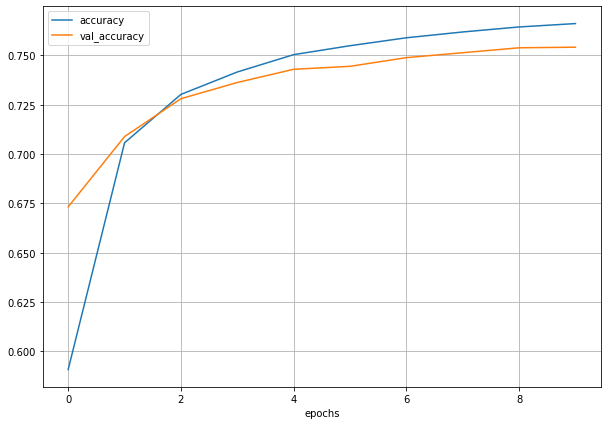

In [18]:
import pandas as pd
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 7))
plt.grid(True)
plt.xlabel('epochs')
plt.show()